In [67]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import ShuffleSplit
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

1

In [68]:
df = pd.read_csv('dataset3_l5.csv', sep=';')

2

In [69]:
print(df.shape[1], ' - кількість полів\n', df.shape[0], ' - кількість записів', sep='')

9 - кількість полів
1030 - кількість записів


3

In [70]:
df.drop('Concrete compressive strength(MPa, megapascals) ', axis=1, inplace=True)

4

In [71]:
for c in df.columns:
  print(f"'{c}'")

'Cement (component 1)(kg in a m^3 mixture)'
'Blast Furnace Slag (component 2)(kg in a m^3 mixture)'
'Fly Ash (component 3)(kg in a m^3 mixture)'
'Water  (component 4)(kg in a m^3 mixture)'
'Superplasticizer (component 5)(kg in a m^3 mixture)'
'Coarse Aggregate  (component 6)(kg in a m^3 mixture)'
'Fine Aggregate (component 7)(kg in a m^3 mixture)'
'Age (day)'


In [72]:
df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day)
0,"540,0","0,0","0,0","162,0","2,5","1040,0","676,0",28
1,"540,0","0,0","0,0","162,0","2,5","1055,0","676,0",28
2,"332,5","142,5","0,0","228,0","0,0","932,0","594,0",270
3,"332,5","142,5","0,0","228,0","0,0","932,0","594,0",365
4,"198,6","132,4","0,0","192,0","0,0","978,4","825,5",360


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 8 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   object
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   object
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   object
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   object
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   object
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   object
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   object
 7   Age (day)                                              1030 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 64.5+ KB


5

In [74]:
# Функція для перетворення рядка у число з плаваючою комою
def convert_to_float(x):
    if isinstance(x, str):
      return float(x.replace(',', '.'))
    return x

# Застосування функції до всіх колонок DataFrame
for column in df.columns:
    df[column] = df[column].apply(convert_to_float)

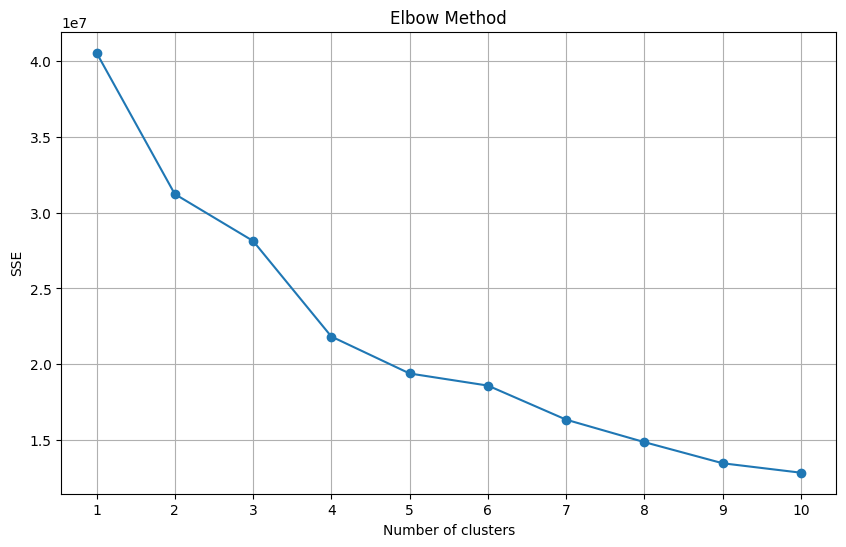

In [75]:
# Метод локтя
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='random', n_init=1, random_state=1)
    kmeans.fit(df)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.xticks(range(1, 11))
plt.grid()
plt.ylabel('SSE')
plt.show()

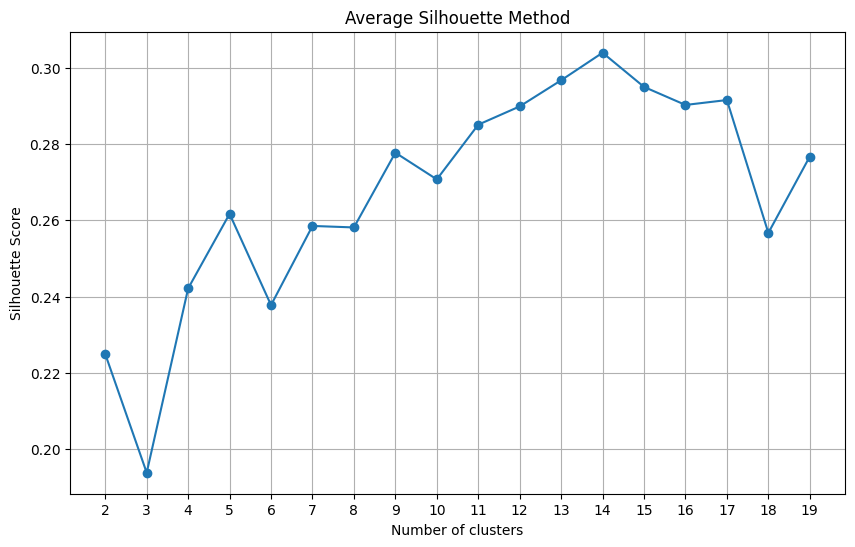

In [76]:
silhouette_scores = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, init='random', n_init=1, random_state=1)
    kmeans.fit(df)
    score = silhouette_score(df, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), silhouette_scores, marker='o')
plt.xticks(range(2, 20))
plt.grid()
plt.title('Average Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

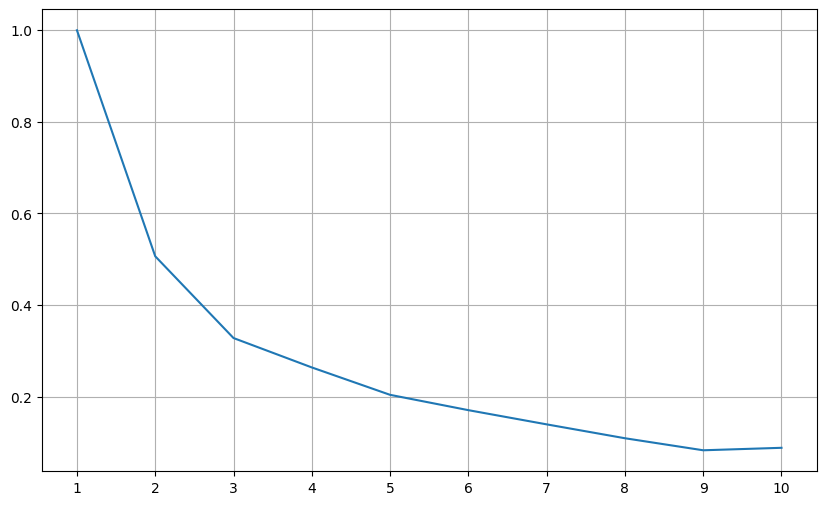

In [77]:
def get_prediction_strength(test_train_pred, test_test_pred, cluster_num):
    d = test_test_pred.shape[0]

    # Створення матриці для зберігання результатів порівняння
    d_arr = np.zeros((d, d), dtype=int)
    for m in range(d):
        for n in range(m + 1, d):
            d_arr[m, n] = int(test_train_pred[m] == test_train_pred[n])
            d_arr[n, m] = d_arr[m, n]

    # Обчислення prediction strength для кожного кластера
    ps = np.inf * np.ones(cluster_num)
    for j in range(cluster_num):
        cluster_indices = (test_test_pred == j)
        len_aj = np.sum(cluster_indices)

        if len_aj > 1:
            d_sum = np.sum(d_arr[cluster_indices][:, cluster_indices])
            ps[j] = d_sum / (len_aj * (len_aj - 1))

    return np.min(ps)

def prediction_strength_method(df):
    spliter = ShuffleSplit(n_splits=3, train_size=0.7, random_state=1)
    pss = {i: [] for i in range(1, 11)}

    for train_df_i, test_df_i in spliter.split(df):
        train_df, test_df = df.loc[train_df_i], df.loc[test_df_i]

        for i in range(1, 11):
            # Кластеризація тестового набору
            test_model = KMeans(n_clusters=i, init='random', n_init=1, random_state=1)
            test_test_pred = test_model.fit_predict(test_df)

            # Кластеризація тренувального набору і прогнозування тестового набору
            train_model = KMeans(n_clusters=i, init='random', n_init=1, random_state=1)
            test_train_pred = train_model.fit_predict(train_df)

            # Обчислення prediction strength
            pss[i].append(get_prediction_strength(test_train_pred, test_test_pred, i))

    # Усереднення значень prediction strength для кожного числа кластерів
    for n in pss:
        pss[n] = np.mean(pss[n])

    return pss

psm = prediction_strength_method(df)

x, y = np.array(list(psm.items())).T
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.xticks(range(1, 11))
plt.grid()
plt.show()

6

In [78]:
optimal_clusters = 4

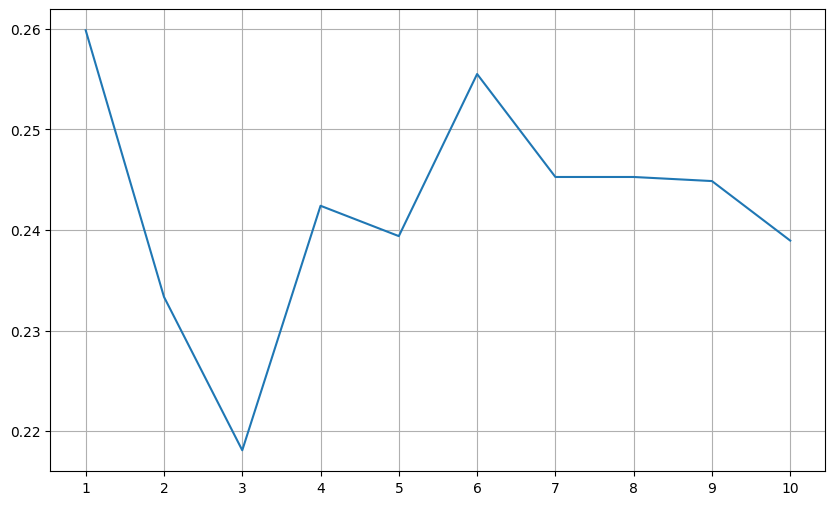

Координати центрів кластерів (k-means++):
[[3.47862264e+02 5.44716981e+01 2.84217094e-14 2.10733962e+02
  3.00000000e-01 9.75352830e+02 6.93498113e+02 2.69641509e+02]
 [3.98848185e+02 3.02231023e+01 2.94924092e+01 1.79296370e+02
  6.91914191e+00 9.54744224e+02 7.70875578e+02 3.07326733e+01]
 [2.22700599e+02 1.17994012e+01 1.04642216e+02 1.73080539e+02
  7.20269461e+00 1.01926108e+03 8.12574850e+02 3.75000000e+01]
 [2.23332941e+02 1.76844412e+02 3.50802941e+01 1.87381471e+02
  5.50794118e+00 9.43212059e+02 7.50168235e+02 3.20705882e+01]]
Найкраща модель: 1


In [86]:
best = 0
best_score = 0
best_model = 0
scores = []
for i in range(10):
  best_kmeans = KMeans(n_clusters=optimal_clusters, n_init=1, init='k-means++')
  best_kmeans.fit(df)
  scores.append(silhouette_score(df, best_kmeans.labels_))
  if scores[-1] > best_score:
    best = i
    best_score = scores[-1]
    best_model = best_kmeans

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), scores)
plt.xticks(range(1, 11))
plt.grid()
plt.show()
print(f"Координати центрів кластерів (k-means++):\n{best_model.cluster_centers_}")
print(f"Найкраща модель: {best+1}")

7

In [80]:
agg_clustering = AgglomerativeClustering(n_clusters=optimal_clusters)
agg_labels = agg_clustering.fit_predict(df)

# Визначення центрів кластерів для AgglomerativeClustering
agg_centers = []
for i in range(optimal_clusters):
    cluster_points = df[agg_labels == i]
    center = cluster_points.mean(axis=0)
    agg_centers.append(center)

8

In [81]:
silhouette_score(df, best_model.labels_)

0.25949017271130465

In [82]:
silhouette_score(df, agg_clustering.labels_)

0.2435424517794043